In [1]:
import re
import pandas as pd
import time
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
warnings.filterwarnings("ignore")
from datetime import datetime
pd.set_option('display.max_columns', None)
import os
import numpy as np

directory_path = 'data_input'
log_file_path = f'{directory_path}/tick_data_20241107_153602.txt'

# Define regex patterns for each log type
request_pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{3}) - Requesting market data for strike price: (\d+), right: (\w), date: (\d+), reqId=(\d+)'
greeks_pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{3}) - GREEKS: ReqId: (\d+), TickType: \d+, IV: ([\d.]+), Delta: ([\d.-]+), OptionPrice: ([\d.-]+|None), Gamma: ([\d.]+), Vega: ([\d.]+), Theta: ([\d.-]+), UnderlyingPrice: ([\d.]+)'
prices_pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{3}) - PRICES: ReqId: (\d+), TickType: (\d+), Price: ([\d.-]+), Attrib: CanAutoExecute: (\d), PastLimit: (\d), PreOpen: (\d)'

# Data lists for each log type
request_data = []
greeks_data = []
prices_data = []

# Read and parse the log file
with open(log_file_path, 'r') as file:
    for line in file:
        # Check for 'Requesting market data' line
        request_match = re.match(request_pattern, line)
        if request_match:
            request_data.append(request_match.groups())
            continue
        
        # Check for 'GREEKS' line
        greeks_match = re.match(greeks_pattern, line)
        if greeks_match:
            greeks_data.append(greeks_match.groups())
            continue
        
        # Check for 'PRICES' line
        prices_match = re.match(prices_pattern, line)
        if prices_match:
            prices_data.append(prices_match.groups())

# Create DataFrames from parsed data
df_requests = pd.DataFrame(request_data, columns=["Timestamp", "StrikePrice", "Right", "Date", "ReqId"])
df_requests["StrikePrice"] = df_requests["StrikePrice"].astype(int)
df_requests["Date"] = pd.to_datetime(df_requests["Date"], format='%Y%m%d')

df_greeks = pd.DataFrame(greeks_data, columns=["Timestamp", "ReqId", "IV", "Delta", "OptionPrice", "Gamma", "Vega", "Theta", "UnderlyingPrice"])
df_greeks["IV"] = df_greeks["IV"].astype(float)
df_greeks["Delta"] = df_greeks["Delta"].astype(float)
df_greeks["OptionPrice"] = pd.to_numeric(df_greeks["OptionPrice"], errors='coerce')
df_greeks["Gamma"] = df_greeks["Gamma"].astype(float)
df_greeks["Vega"] = df_greeks["Vega"].astype(float)
df_greeks["Theta"] = df_greeks["Theta"].astype(float)
df_greeks["UnderlyingPrice"] = df_greeks["UnderlyingPrice"].astype(float)

df_prices = pd.DataFrame(prices_data, columns=["Timestamp", "ReqId", "TickType", "Price", "CanAutoExecute", "PastLimit", "PreOpen"])
df_prices["Price"] = df_prices["Price"].astype(float)
df_prices["TickType"] = df_prices["TickType"].astype(int)
df_prices["CanAutoExecute"] = df_prices["CanAutoExecute"].astype(int)
df_prices["PastLimit"] = df_prices["PastLimit"].astype(int)
df_prices["PreOpen"] = df_prices["PreOpen"].astype(int)

In [2]:
df_requests

,Timestamp,StrikePrice,Right,Date,ReqId
0,2024-11-07 15:36:06.115,593,P,2024-11-07,101
1,2024-11-07 15:36:06.115,593,C,2024-11-07,102


In [3]:
fecha = pd.to_datetime(df_requests.loc[0, 'Date']).date()
print(fecha)

2024-11-07


In [4]:
df_greeks

,Timestamp,ReqId,IV,Delta,OptionPrice,Gamma,Vega,Theta,UnderlyingPrice
0,2024-11-07 15:36:06.338,101,0.2704,-0.4744,NaN,0.0905,0.0650,-1.6600,593.250000
1,2024-11-07 15:36:06.419,101,0.2704,-0.4735,NaN,0.0904,0.0650,-1.6600,593.260000
2,2024-11-07 15:36:06.537,102,0.2716,0.5267,NaN,0.0900,0.0650,-1.6192,593.260000
3,2024-11-07 15:36:06.555,101,0.2704,-0.4735,1.66,0.0904,0.0650,-1.6600,593.260000
4,2024-11-07 15:36:06.719,102,0.2716,0.5267,1.90,0.0900,0.0650,-1.6192,593.260000
...,...,...,...,...,...,...,...,...,...
12754,2024-11-07 20:28:52.089,102,0.3512,0.7306,2.32,0.1115,0.0283,-0.5044,594.809998
12755,2024-11-07 20:28:54.139,101,0.3660,-0.2784,0.54,0.1086,0.0299,-0.5400,594.804993
12756,2024-11-07 20:28:54.139,102,0.3512,0.7301,2.34,0.1116,0.0286,-0.5294,594.804993
12757,2024-11-07 20:28:56.013,101,0.3660,-0.2768,0.54,0.1089,0.0297,-0.5400,594.809998


In [5]:
df_prices

,Timestamp,ReqId,TickType,Price,CanAutoExecute,PastLimit,PreOpen
0,2024-11-07 15:36:06.718,101,1,1.64,0,0,0
1,2024-11-07 15:36:06.889,102,1,1.90,0,0,0
2,2024-11-07 15:36:07.577,101,1,1.63,0,0,0
3,2024-11-07 15:36:07.577,102,1,1.91,0,0,0
4,2024-11-07 15:36:07.577,101,1,1.64,0,0,0
...,...,...,...,...,...,...,...
43812,2024-11-07 20:28:52.767,102,1,2.33,0,0,0
43813,2024-11-07 20:28:53.296,102,1,2.32,0,0,0
43814,2024-11-07 20:28:53.456,102,1,2.33,0,0,0
43815,2024-11-07 20:28:53.797,102,1,2.34,0,0,0


CONSTRUCCIÓN DATAFRAME PUTS

In [6]:
df_greeks_P = df_greeks[df_greeks['ReqId'] == '101']
#df_greeks_P

In [7]:
df_prices_P = df_prices[df_prices['ReqId'] == '101']
#df_prices_P

In [8]:
strike_price = df_requests.loc[df_requests['ReqId'] == '101', 'StrikePrice'].values[0]
tipo = df_requests.loc[df_requests['ReqId'] == '101', 'Right'].values[0]
date = df_requests.loc[df_requests['ReqId'] == '101', 'Date'].values[0]
date = pd.to_datetime(date).date()
print(strike_price)
print(tipo)
print(date)

593
P
2024-11-07


In [9]:
df_greeks_P['Timestamp'] = pd.to_datetime(df_greeks_P['Timestamp'])
df_prices_P['Timestamp'] = pd.to_datetime(df_prices_P['Timestamp'])

# Ordena ambos DataFrames por la columna 'Timestamp' para que el merge_asof funcione correctamente
df1 = df_greeks_P.sort_values(by='Timestamp')
df2 = df_prices_P.sort_values(by='Timestamp')

# Realiza una unión "asof" en el campo 'Timestamp', uniendo filas de acuerdo al valor más cercano de Timestamp
# Esta unión no es estrictamente igual (como un "join" clásico) sino que une la información más próxima
df_P = pd.merge_asof(df1, df2, on='Timestamp', direction='nearest')
df_P = df_P.drop(columns=['ReqId_y','CanAutoExecute','PastLimit', 'PastLimit','PreOpen'])
df_P['ReqId_x'] = 'P'

In [10]:
#df_P

CONSTRUCCIÓN DATAFRAME CALLS

In [11]:
df_greeks_C = df_greeks[df_greeks['ReqId'] == '102']
#df_greeks_C

In [12]:
df_prices_C = df_prices[df_prices['ReqId'] == '102']
#df_prices_C

In [13]:
df_greeks_C['Timestamp'] = pd.to_datetime(df_greeks_C['Timestamp'], errors='coerce')
df_prices_C['Timestamp'] = pd.to_datetime(df_prices_C['Timestamp'], errors='coerce')

# Drop rows with NaT (invalid datetime) in 'Timestamp' column
df_greeks_C = df_greeks_C.dropna(subset=['Timestamp'])
df_prices_C = df_prices_C.dropna(subset=['Timestamp'])

# Ordena ambos DataFrames por la columna 'Timestamp' para que el merge_asof funcione correctamente
df1 = df_greeks_C.sort_values(by='Timestamp')
df2 = df_prices_C.sort_values(by='Timestamp')

# Realiza una unión "asof" en el campo 'Timestamp', uniendo filas de acuerdo al valor más cercano de Timestamp
# Esta unión no es estrictamente igual (como un "join" clásico) sino que une la información más próxima
df_C = pd.merge_asof(df1, df2, on='Timestamp', direction='nearest')
df_C = df_C.drop(columns=['ReqId_y','CanAutoExecute','PastLimit', 'PreOpen'])
df_C['ReqId_x'] = 'C'

In [14]:
df_P.rename(columns={col: f"{col}_P" for col in df_P.columns}, inplace=True)
df_C.rename(columns={col: f"{col}_C" for col in df_C.columns}, inplace=True)

Dataframes

In [15]:
#df_C

In [16]:
#df_P

In [17]:
window_size = 10  # Puedes ajustar el tamaño de la ventana según lo desees
df_C['Price_C'] = df_C['Price_C'].rolling(window=window_size).mean()
df_P['Price_P'] = df_P['Price_P'].rolling(window=window_size).mean()

In [18]:
#ajuste particular
df_C = df_C[df_C['Price_C'] >= 1.7]

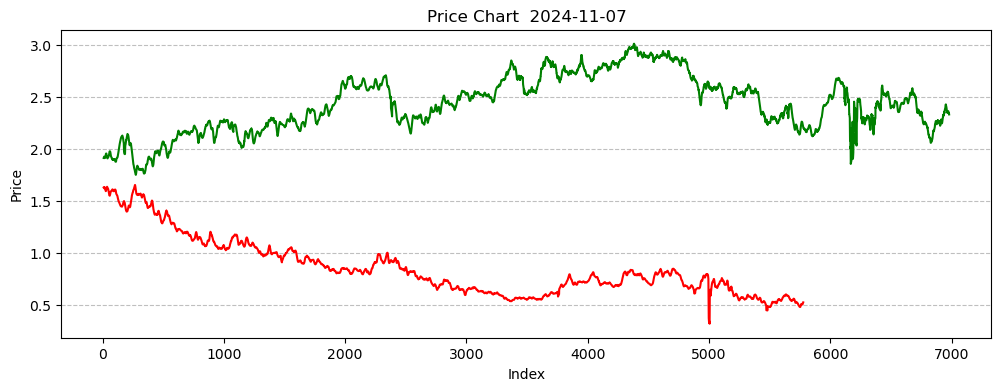

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(df_P.index, df_P['Price_P'], color='red')
plt.plot(df_C.index, df_C['Price_C'], color='green')
plt.title(f'Price Chart  {fecha}')
plt.xlabel('Index')
plt.ylabel('Price')
plt.grid(axis='y', color='grey', linestyle='--', alpha=0.5)
plt.show()

CREACIÓN DATAFRAME

In [20]:
# Ordena ambos DataFrames por la columna 'Timestamp' para que el merge_asof funcione correctamente
df1 = df_P.sort_values(by='Timestamp_P')
df2 = df_C.sort_values(by='Timestamp_C')

# Realiza una unión "asof" en el campo 'Timestamp', uniendo filas de acuerdo al valor más cercano de Timestamp
# Esta unión no es estrictamente igual (como un "join" clásico) sino que une la información más próxima
df = pd.merge_asof(df1, df2, left_on='Timestamp_P', right_on='Timestamp_C', direction='nearest')
df = df.drop(columns=[
    'ReqId_x_P', 
    'UnderlyingPrice_P', 
    'Timestamp_C', 
    'ReqId_x_C', 
    'OptionPrice_P', 
    'OptionPrice_C', 
    'TickType_P', 
    'TickType_C',
    'IV_C'
])
df = df.rename(columns={
    'Timestamp_P': 'Timestamp',
    'IV_P': 'IV',
    'UnderlyingPrice_C': 'UnderlyingPrice'
})
df['UnderlyingPrice'] = round(df['UnderlyingPrice'],2)

In [21]:
#df.info()

In [22]:
df['Price'] = df['Price_P'] + df['Price_C']
df['Delta'] = df['Delta_P'] + df['Delta_C']
df['Gamma'] = df['Gamma_P'] + df['Gamma_C']
df['Theta'] = df['Theta_P'] + df['Theta_C']
df['Vega'] = df['Vega_P'] + df['Vega_C']

In [23]:
# Ajuste particular
df = df[df['Price'] >= 2.8]

In [24]:
# CÁLCULO IMPACTOS

# IMPACTO DEL IV
df['diff_IV'] = df['IV'].diff()
df['impact_vega'] = df['diff_IV'] * df['Vega'] *100

## IMPACTO DEL TIEMPO
df['diff_Timestamp'] = df['Timestamp'].diff().dt.total_seconds() / 86400
df['impact_theta'] = df['diff_Timestamp'] * df['Theta']
df['impact_theta'] = df['impact_theta'].rolling(window=10).mean()

# IMPACTO DEL DELTA
df['diff_Underlyting'] = df['UnderlyingPrice'].diff()
df['impact_delta'] = df['diff_Underlyting'] * df['Delta']
df['impact_delta'] = df['impact_delta'].rolling(window=20).mean()

REPARTO PERCENT IMPACTOS

In [25]:
df['impacto'] = abs(df['impact_delta']) + abs(df['impact_theta']) + abs(df['impact_vega'])

# Avoid division by zero by replacing zeroes in 'impacto' with NaN
df['impacto'].replace(0, np.nan, inplace=True)

# Calculate percentages
df['delta_pct'] = abs(round(df['impact_delta'] / df['impacto'], 2) * 100)
df['theta_pct'] = abs(round(df['impact_theta'] / df['impacto'], 2) * 100)
df['vega_pct'] = abs(round(df['impact_vega'] / df['impacto'], 2) * 100)
df['total'] = df['delta_pct'] + df['theta_pct'] + df['vega_pct'] 

In [26]:
df['impact_vega_acumulado'] = df['impact_vega'].cumsum()
df['impact_delta_acumulado'] = df['impact_delta'].cumsum()
df['impact_theta_acumulado'] = df['impact_theta'].cumsum()
df

,Timestamp,IV,Delta_P,Gamma_P,Vega_P,Theta_P,Price_P,Delta_C,Gamma_C,Vega_C,Theta_C,UnderlyingPrice,Price_C,Price,Delta,Gamma,Theta,Vega,diff_IV,impact_vega,diff_Timestamp,impact_theta,diff_Underlyting,impact_delta,impacto,delta_pct,theta_pct,vega_pct,total,impact_vega_acumulado,impact_delta_acumulado,impact_theta_acumulado
9,2024-11-07 15:36:20.149,0.2704,-0.4681,0.0903,0.0650,-1.64,1.629,0.5320,0.0898,0.0650,-1.5892,593.32,1.914,3.543,0.0639,0.1801,-3.2292,0.1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2024-11-07 15:36:22.239,0.2704,-0.4690,0.0903,0.0650,-1.62,1.627,0.5311,0.0898,0.0650,-1.6092,593.31,1.918,3.545,0.0621,0.1801,-3.2292,0.1300,0.0,0.0,0.000024,NaN,-0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
11,2024-11-07 15:36:24.159,0.2704,-0.4681,0.0903,0.0650,-1.62,1.626,0.5320,0.0898,0.0650,-1.5991,593.32,1.921,3.547,0.0639,0.1801,-3.2191,0.1300,0.0,0.0,0.000022,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
12,2024-11-07 15:36:26.254,0.2704,-0.4699,0.0903,0.0650,-1.63,1.624,0.5303,0.0899,0.0650,-1.6090,593.30,1.924,3.548,0.0604,0.1802,-3.2390,0.1300,0.0,0.0,0.000024,NaN,-0.02,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
13,2024-11-07 15:36:28.184,0.2704,-0.4681,0.0903,0.0650,-1.63,1.621,0.5320,0.0898,0.0650,-1.5891,593.32,1.927,3.548,0.0639,0.1801,-3.2191,0.1300,0.0,0.0,0.000022,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5773,2024-11-07 20:28:48.251,0.3660,-0.2767,0.1083,0.0299,-0.52,0.508,0.7316,0.1112,0.0276,-0.5443,594.82,2.351,2.859,0.4549,0.2195,-1.0643,0.0575,0.0,0.0,0.000024,-0.000028,-0.02,-0.002743,0.002771,99.0,1.0,0.0,100.0,0.742541,0.641540,-0.326115
5774,2024-11-07 20:28:50.153,0.3660,-0.2722,0.1076,0.0299,-0.52,0.511,0.7358,0.1102,0.0265,-0.5045,594.86,2.346,2.857,0.4636,0.2178,-1.0245,0.0564,0.0,0.0,0.000022,-0.000028,0.04,-0.001337,0.001365,98.0,2.0,0.0,100.0,0.742541,0.640203,-0.326143
5775,2024-11-07 20:28:52.089,0.3660,-0.2778,0.1085,0.0299,-0.54,0.515,0.7306,0.1115,0.0283,-0.5044,594.81,2.346,2.861,0.4528,0.2200,-1.0444,0.0582,0.0,0.0,0.000022,-0.000028,-0.05,-0.001072,0.001099,97.0,3.0,0.0,100.0,0.742541,0.639131,-0.326171
5776,2024-11-07 20:28:54.139,0.3660,-0.2784,0.1086,0.0299,-0.54,0.518,0.7301,0.1116,0.0286,-0.5294,594.80,2.342,2.860,0.4517,0.2202,-1.0694,0.0585,0.0,0.0,0.000024,-0.000028,-0.01,-0.001066,0.001094,97.0,3.0,0.0,100.0,0.742541,0.638065,-0.326199


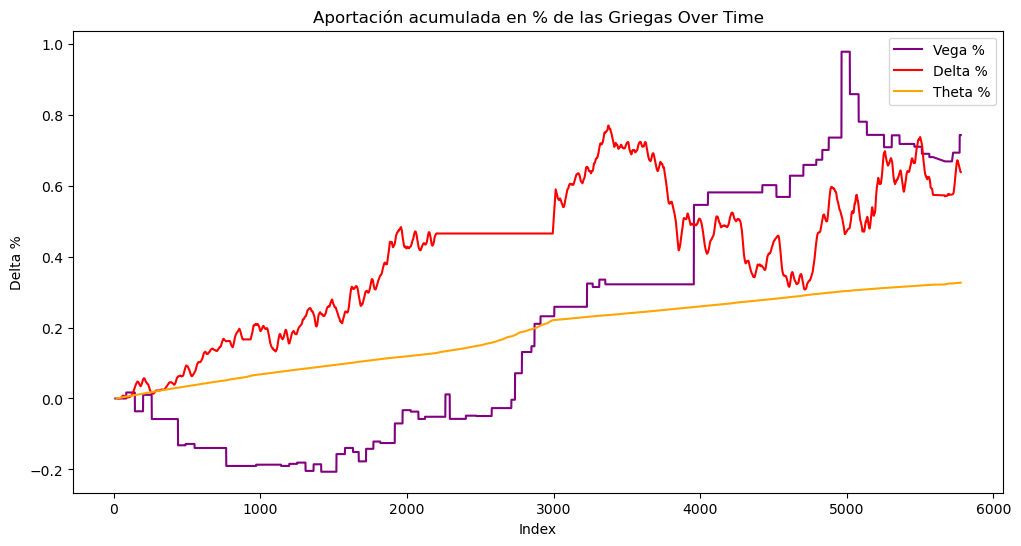

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['impact_vega_acumulado'], linestyle='-', label='Vega %', color = 'purple')
plt.plot(df.index, df['impact_delta_acumulado'], linestyle='-', label='Delta %', color = 'red')
plt.plot(df.index, abs(df['impact_theta_acumulado']), linestyle='-', label='Theta %', color = 'orange')
plt.title('Aportación acumulada en % de las Griegas Over Time')
plt.xlabel('Index')
plt.ylabel('Delta %')
plt.legend()
plt.show()

In [28]:
# aportación acumulada de cada griega a lo largo del tiempo en %
df['impacto_cum'] = abs(df['impact_vega_acumulado']) + abs(df['impact_delta_acumulado']) + abs(df['impact_theta_acumulado'])

# Avoid division by zero by replacing zeroes in 'impacto' with NaN
df['impacto'].replace(0, np.nan, inplace=True)

# Calculate percentages
df['delta_pct_cum'] = abs(round(df['impact_delta_acumulado'] / df['impacto_cum'], 2) * 100)
df['theta_pct_cum'] = abs(round(df['impact_theta_acumulado'] / df['impacto_cum'], 2) * 100)
df['vega_pct_cum'] = abs(round(df['impact_vega_acumulado'] / df['impacto_cum'], 2) * 100)
df['total'] = df['delta_pct_cum'] + df['theta_pct_cum'] + df['vega_pct_cum'] 

In [29]:
#SUBSEGMENTOS
df = df.iloc[0:20000]
df

,Timestamp,IV,Delta_P,Gamma_P,Vega_P,Theta_P,Price_P,Delta_C,Gamma_C,Vega_C,Theta_C,UnderlyingPrice,Price_C,Price,Delta,Gamma,Theta,Vega,diff_IV,impact_vega,diff_Timestamp,impact_theta,diff_Underlyting,impact_delta,impacto,delta_pct,theta_pct,vega_pct,total,impact_vega_acumulado,impact_delta_acumulado,impact_theta_acumulado,impacto_cum,delta_pct_cum,theta_pct_cum,vega_pct_cum
9,2024-11-07 15:36:20.149,0.2704,-0.4681,0.0903,0.0650,-1.64,1.629,0.5320,0.0898,0.0650,-1.5892,593.32,1.914,3.543,0.0639,0.1801,-3.2292,0.1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2024-11-07 15:36:22.239,0.2704,-0.4690,0.0903,0.0650,-1.62,1.627,0.5311,0.0898,0.0650,-1.6092,593.31,1.918,3.545,0.0621,0.1801,-3.2292,0.1300,0.0,0.0,0.000024,NaN,-0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
11,2024-11-07 15:36:24.159,0.2704,-0.4681,0.0903,0.0650,-1.62,1.626,0.5320,0.0898,0.0650,-1.5991,593.32,1.921,3.547,0.0639,0.1801,-3.2191,0.1300,0.0,0.0,0.000022,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
12,2024-11-07 15:36:26.254,0.2704,-0.4699,0.0903,0.0650,-1.63,1.624,0.5303,0.0899,0.0650,-1.6090,593.30,1.924,3.548,0.0604,0.1802,-3.2390,0.1300,0.0,0.0,0.000024,NaN,-0.02,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
13,2024-11-07 15:36:28.184,0.2704,-0.4681,0.0903,0.0650,-1.63,1.621,0.5320,0.0898,0.0650,-1.5891,593.32,1.927,3.548,0.0639,0.1801,-3.2191,0.1300,0.0,0.0,0.000022,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5773,2024-11-07 20:28:48.251,0.3660,-0.2767,0.1083,0.0299,-0.52,0.508,0.7316,0.1112,0.0276,-0.5443,594.82,2.351,2.859,0.4549,0.2195,-1.0643,0.0575,0.0,0.0,0.000024,-0.000028,-0.02,-0.002743,0.002771,99.0,1.0,0.0,100.0,0.742541,0.641540,-0.326115,1.710196,38.0,19.0,43.0
5774,2024-11-07 20:28:50.153,0.3660,-0.2722,0.1076,0.0299,-0.52,0.511,0.7358,0.1102,0.0265,-0.5045,594.86,2.346,2.857,0.4636,0.2178,-1.0245,0.0564,0.0,0.0,0.000022,-0.000028,0.04,-0.001337,0.001365,98.0,2.0,0.0,99.0,0.742541,0.640203,-0.326143,1.708887,37.0,19.0,43.0
5775,2024-11-07 20:28:52.089,0.3660,-0.2778,0.1085,0.0299,-0.54,0.515,0.7306,0.1115,0.0283,-0.5044,594.81,2.346,2.861,0.4528,0.2200,-1.0444,0.0582,0.0,0.0,0.000022,-0.000028,-0.05,-0.001072,0.001099,97.0,3.0,0.0,99.0,0.742541,0.639131,-0.326171,1.707843,37.0,19.0,43.0
5776,2024-11-07 20:28:54.139,0.3660,-0.2784,0.1086,0.0299,-0.54,0.518,0.7301,0.1116,0.0286,-0.5294,594.80,2.342,2.860,0.4517,0.2202,-1.0694,0.0585,0.0,0.0,0.000024,-0.000028,-0.01,-0.001066,0.001094,97.0,3.0,0.0,100.0,0.742541,0.638065,-0.326199,1.706805,37.0,19.0,44.0


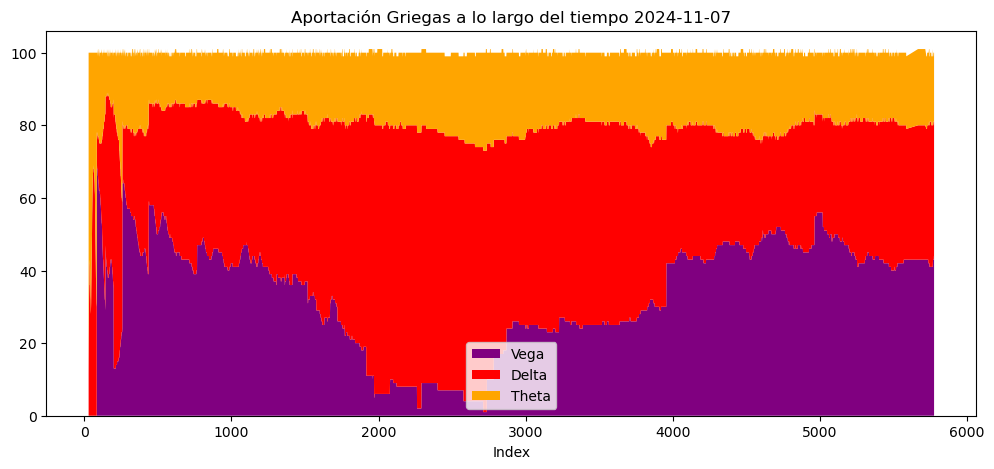

In [30]:
plt.figure(figsize=(12, 5))
plt.stackplot(
    df.index, 
    df['vega_pct_cum'],
    df['delta_pct_cum'], 
    df['theta_pct_cum'], 
    labels=['Vega', 'Delta', 'Theta'], 
    colors=['purple', 'red','orange']
)
plt.title(f'Aportación Griegas a lo largo del tiempo {fecha}')
plt.xlabel('Index')
plt.legend(loc='lower center')
plt.show()

DETALLE VEGA Y VOLATILIDAD

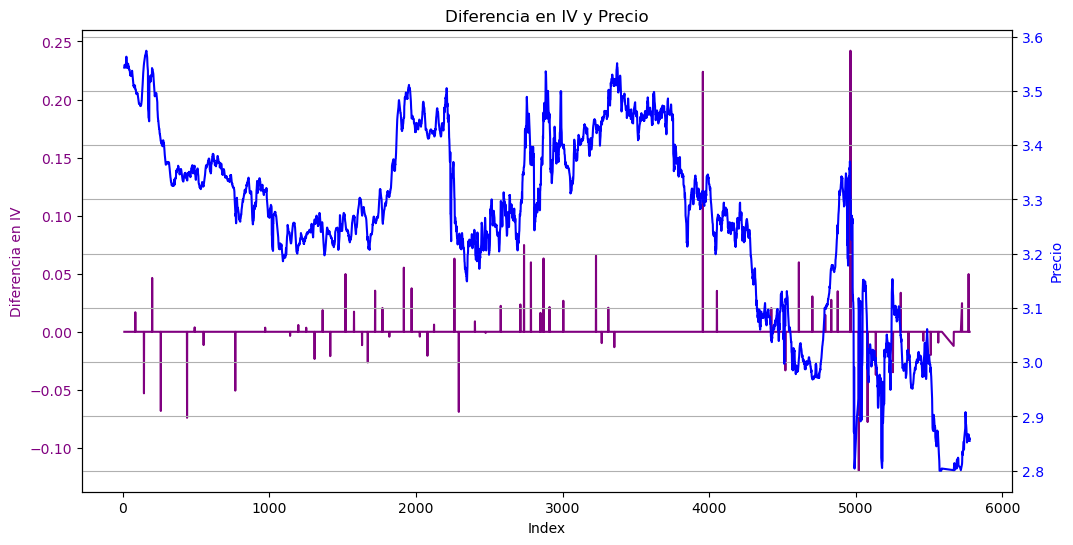

In [31]:
# Crear el gráfico
fig, ax1 = plt.subplots(figsize=(12, 6))

# Graficar 'diff_IV' en el eje izquierdo
ax1.plot(df.index, df['impact_vega'], color='purple', label='Diferencia en IV')
ax1.set_xlabel('Index')
ax1.set_ylabel('Diferencia en IV', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

# Crear un segundo eje y para 'Price'
ax2 = ax1.twinx()
ax2.plot(df.index, df['Price'], color='blue', label='Precio')
ax2.set_ylabel('Precio', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Título y cuadrícula
plt.title('Diferencia en IV y Precio')
plt.grid(True)

# Mostrar el gráfico
plt.show()

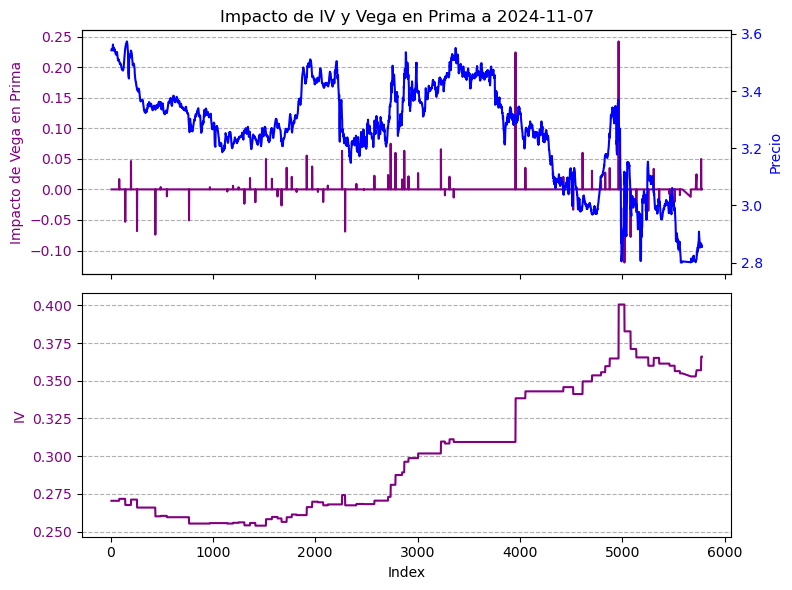

In [32]:
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
ax1.plot(df.index, df['impact_vega'], color='purple', label='Impacto de IV y Vega en Prima')
ax1.set_ylabel('Impacto de Vega en Prima', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')
ax1.grid(axis='y', linestyle='--')
ax1.set_title(f'Impacto de IV y Vega en Prima a {fecha}')
ax2 = ax1.twinx()
ax2.plot(df.index, df['Price'], color='blue', label='Precio')
ax2.set_ylabel('Precio', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax3.plot(df.index, df['IV'], color='purple', label='Volatilidad Implícita (IV)')
ax3.set_xlabel('Index')
ax3.set_ylabel('IV', color='purple')
ax3.tick_params(axis='y', labelcolor='purple')
ax3.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

DETALLE THETA Y TIEMPO

In [33]:
# ajuste particular theta
df = df[df['impact_theta'] >= -0.000150]

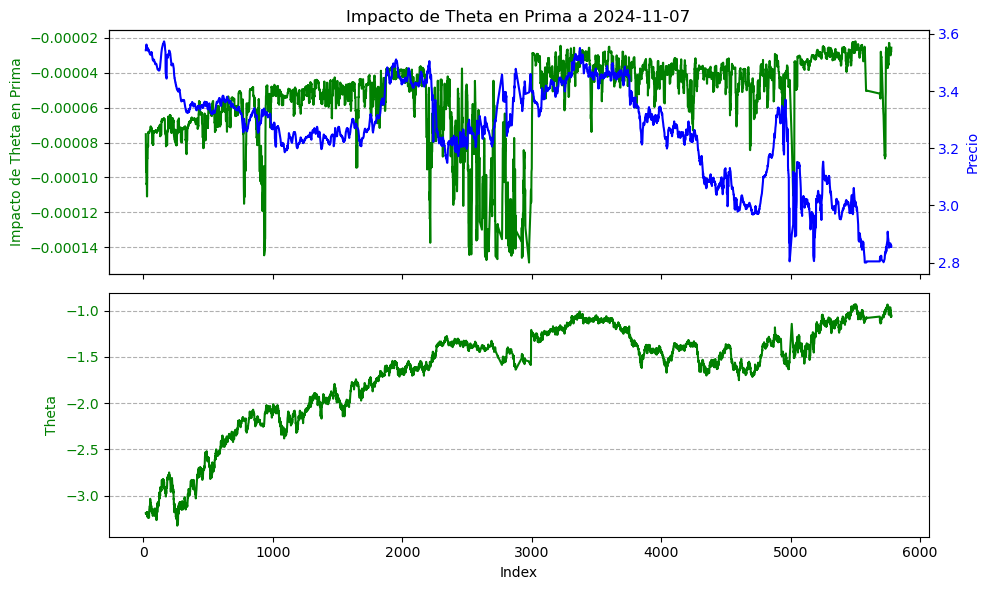

In [34]:
# Crear un gráfico con un subplot adicional para graficar 'theta' en morado
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Graficar 'impact_theta' en el eje izquierdo (ax1)
ax1.plot(df.index, df['impact_theta'], color='green', label='Impacto de Theta en Prima')
ax1.set_ylabel('Impacto de Theta en Prima', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.grid(axis='y', linestyle='--')
ax1.set_title(f'Impacto de Theta en Prima a {fecha}')

ax2 = ax1.twinx()
ax2.plot(df.index, df['Price'], color='blue', label='Precio')
ax2.set_ylabel('Precio', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Graficar 'theta' en el subplot adicional (ax3)
ax3.plot(df.index, df['Theta'], color='green', label='Theta')
ax3.set_xlabel('Index')
ax3.set_ylabel('Theta', color='green')
ax3.tick_params(axis='y', labelcolor='green')
ax3.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

In [35]:
indice = 150 # Replace with the index number you want
hora =  df.iloc[indice]['Timestamp']
print(hora)

2024-11-07 15:41:56.113000


In [36]:
first = 5  # Número de filas a eliminar al inicio
last = 5  # Número de filas a eliminar al final
# Eliminar las primeras n y últimas m filas
#df = df.iloc[first:-last]

DETALLE DELTA Y TIEMPO

In [37]:
# ajuste particular theta
df = df[df['impact_delta'] <= 0.005]

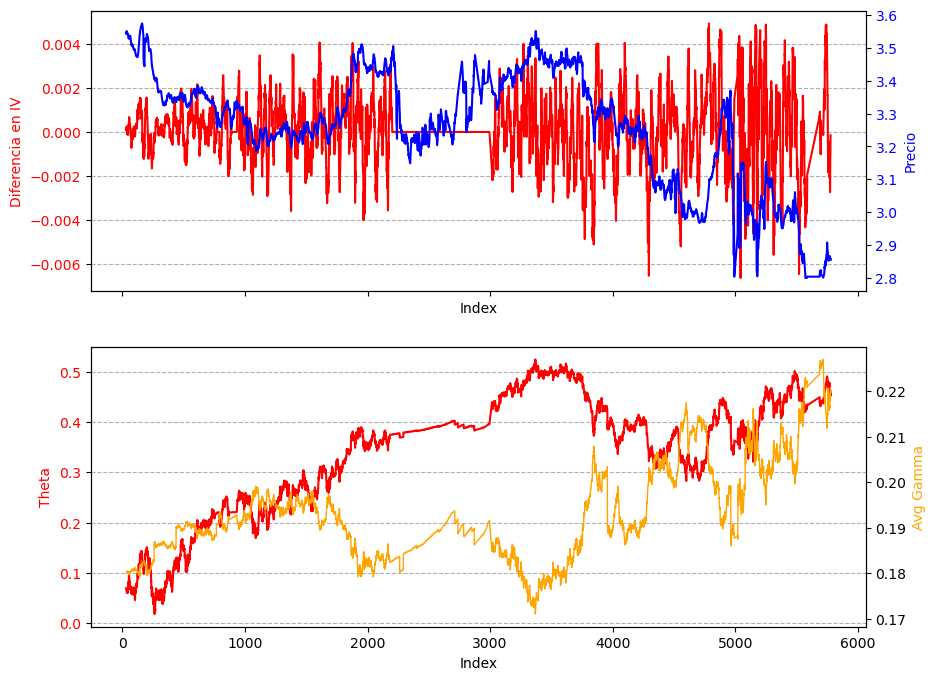

In [38]:
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax1.plot(df.index, df['impact_delta'], color='red', label='Diferencias en Deltas_Impact')
ax1.set_xlabel('Index')
ax1.set_ylabel('Diferencia en IV', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(axis='y', linestyle='--')
ax2 = ax1.twinx()
ax2.plot(df.index, df['Price'], color='blue', label='Precio')
ax2.set_ylabel('Precio', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax3.plot(df.index, df['Delta'], color='red', label='Delta')
ax3.set_xlabel('Index')
ax3.set_ylabel('Theta', color='red')
ax3.tick_params(axis='y', labelcolor='red')
ax3.grid(axis='y', linestyle='--')
ax4 = ax3.twinx()
ax4.plot(df.index, df['Gamma'], color='orange', label='Avg_Gamma', linewidth=1)
ax4.set_ylabel('Avg Gamma')
ax4.yaxis.label.set_color('orange')
plt.show()

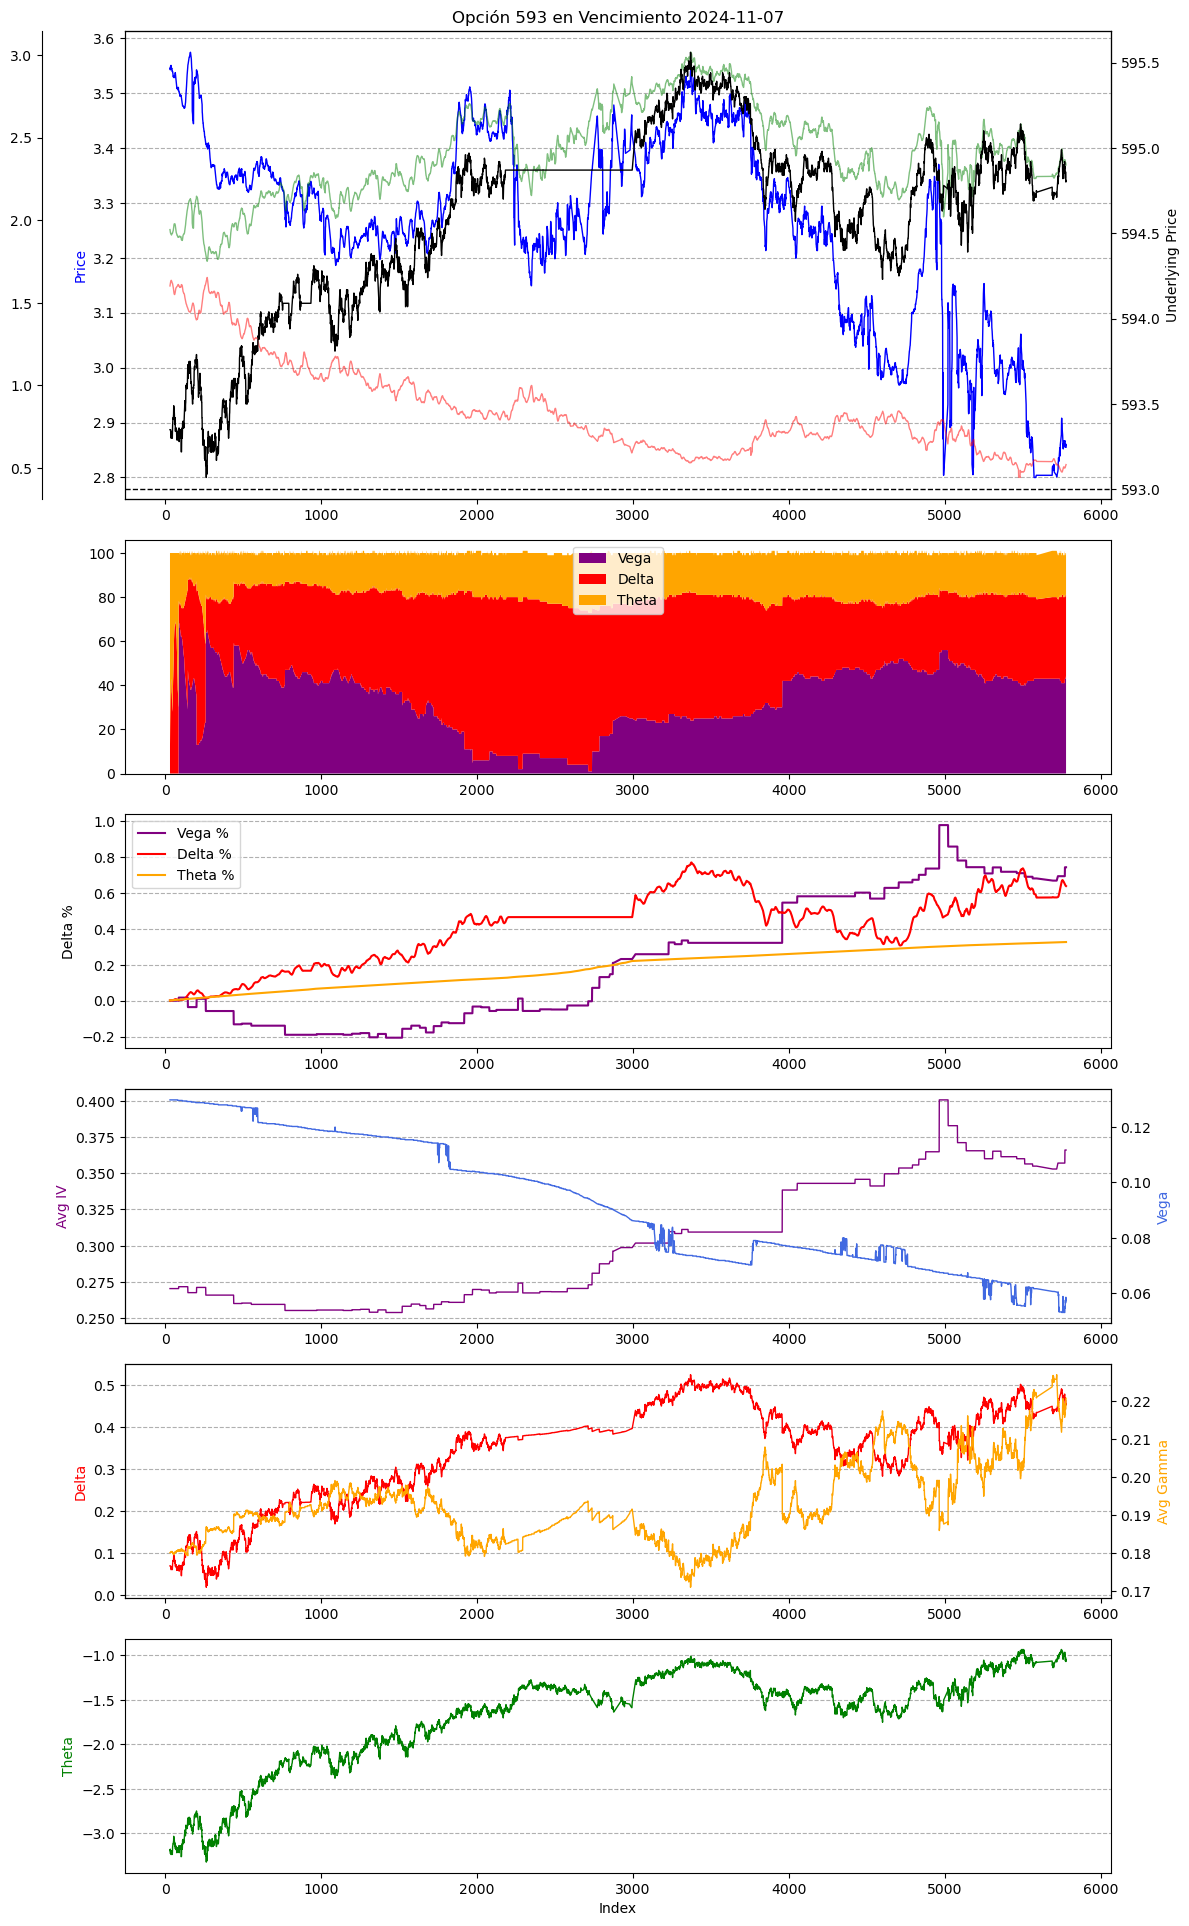

In [39]:
fig = plt.figure(figsize=(12, 20))
gs = gridspec.GridSpec(6, 1, height_ratios=[2, 1, 1, 1, 1, 1])  

ax1 = fig.add_subplot(gs[0])
ax1.plot(df.index, df['Price'], color='blue', label='Price', linewidth=1)
ax1.set_ylabel('Price')
ax1.yaxis.label.set_color('blue')
ax1.grid(axis='y', linestyle='--')

ax1b = ax1.twinx()
ax1b.spines['left'].set_position(('outward', 60))
ax1b.spines['left'].set_visible(True)
ax1b.yaxis.set_label_position('left')
ax1b.yaxis.set_ticks_position('left')
ax1b.plot(df.index, df['Price_P'], color='red', label='Price_P', linewidth=1, alpha=0.5)
ax1b.plot(df.index, df['Price_C'], color='green', label='Price_C', linewidth=1, alpha=0.5)
ax1b.yaxis.label.set_color('green')

ax2 = ax1.twinx()
ax2.plot(df.index, df['UnderlyingPrice'], color='black', label='UnderlyingPrice', linewidth=1)
ax2.set_ylabel('Underlying Price')
ax2.axhline(y=strike_price, color='black', linestyle='--', linewidth=1)
ax2.yaxis.label.set_color('black')
ax1.set_title(f'Opción {strike_price} en Vencimiento {fecha}')

ax3 = fig.add_subplot(gs[3])
ax3.plot(df.index, df['IV'], color='purple', label='Avg_IV', linewidth=1)
ax3.set_ylabel('Avg IV')
ax3.yaxis.label.set_color('purple')
ax3.grid(axis='y', linestyle='--')

ax3_vega = ax3.twinx()
ax3_vega.plot(df.index, df['Vega'], color='royalblue', label='Avg_Vega', linewidth=1)
ax3_vega.set_ylabel('Vega')
ax3_vega.yaxis.label.set_color('royalblue')

# Plot for 'Delta' and 'Gamma'
ax5 = fig.add_subplot(gs[4])
ax5.plot(df.index, df['Delta'], color='red', label='Delta', linewidth=1)
ax5.set_ylabel('Delta')
ax5.yaxis.label.set_color('red')
ax5.grid(axis='y', linestyle='--')

ax6 = ax5.twinx()
ax6.plot(df.index, df['Gamma'], color='orange', label='Avg_Gamma', linewidth=1)
ax6.set_ylabel('Avg Gamma')
ax6.yaxis.label.set_color('orange')

ax7 = fig.add_subplot(gs[5])
ax7.plot(df.index, df['Theta'], color='green', label='Theta', linewidth=1)
ax7.set_ylabel('Theta')
ax7.yaxis.label.set_color('green')
ax7.set_xlabel('Index')
ax7.grid(axis='y', linestyle='--')

ax8 = fig.add_subplot(gs[1])
ax8.stackplot(
    df.index, 
    df['vega_pct_cum'], 
    df['delta_pct_cum'], 
    df['theta_pct_cum'], 
    labels=['Vega', 'Delta', 'Theta'], 
    colors=['purple', 'red', 'orange']
)
#ax8.set_title(f'Accumulated Percentages Over Time {fecha}')
ax8.legend(loc='upper center')
ax9 = fig.add_subplot(gs[2])
ax9.plot(df.index, df['impact_vega_acumulado'], linestyle='-', label='Vega %', color='purple')
ax9.plot(df.index, df['impact_delta_acumulado'], linestyle='-', label='Delta %', color='red')
ax9.plot(df.index, abs(df['impact_theta_acumulado']), linestyle='-', label='Theta %', color='orange')
#ax9.set_title('Aportación acumulada en % de las Griegas Over Time')
ax9.set_ylabel('Delta %')
ax9.legend()
ax9.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.15)
plt.show()

SEGMENTOS

In [40]:
inicio = 10

# Access values using .iloc for positional indexing
Timestamp_inicio = df.iloc[inicio]['Timestamp']
UnderlyingPrice_inicio = df.iloc[inicio]['UnderlyingPrice']
delta_inicio = df.iloc[inicio]['Delta']
theta_inicio = df.iloc[inicio]['Theta']
vega_inicio = df.iloc[inicio]['Vega']
gamma_inicio = df.iloc[inicio]['Gamma']
IV_inicio = df.iloc[inicio]['IV']
Precio_inicio = df.iloc[inicio]['Price']

# Print the retrieved values to verify
print("Timestamp:", Timestamp_inicio)
print("Underlying Price:", UnderlyingPrice_inicio)
print("Delta:", delta_inicio)
print("Theta:", theta_inicio)
print("Vega:", vega_inicio)
print("Gamma:", gamma_inicio)
print("IV:", IV_inicio)
print("Price:", Precio_inicio)


Timestamp: 2024-11-07 15:37:30.100000
Underlying Price: 593.33
Delta: 0.06580000000000003
Theta: -3.2092
Vega: 0.1298
Gamma: 0.1803
IV: 0.2704
Price: 3.543


In [41]:
fin = 120

# Access values using .iloc for positional indexing
Timestamp_fin = df.iloc[fin]['Timestamp']
UnderlyingPrice_fin = df.iloc[fin]['UnderlyingPrice']
delta_fin = df.iloc[fin]['Delta']
theta_fin = df.iloc[fin]['Theta']
vega_fin = df.iloc[fin]['Vega']
gamma_fin = df.iloc[fin]['Gamma']
IV_fin = df.iloc[fin]['IV']
Precio_fin = df.iloc[fin]['Price']

# Calculate the difference in 'Price'
diff_precio = Precio_fin - Precio_inicio

# Print the results
print("Timestamp (fin):", Timestamp_fin)
print("Underlying Price (fin):", UnderlyingPrice_fin)
print("Delta (fin):", delta_fin)
print("Theta (fin):", theta_fin)
print("Vega (fin):", vega_fin)
print("Gamma (fin):", gamma_fin)
print("IV (fin):", IV_fin)
print("Price (fin):", Precio_fin)
print("Difference in Price:", diff_precio)


Timestamp (fin): 2024-11-07 15:41:14.122000
Underlying Price (fin): 593.7
Delta (fin): 0.13440000000000002
Theta (fin): -2.8594
Vega (fin): 0.1292
Gamma (fin): 0.18159999999999998
IV (fin): 0.2676
Price (fin): 3.5589999999999993
Difference in Price: 0.015999999999999126


In [42]:
print(f"Timestamp:          {Timestamp_inicio} -> {Timestamp_fin}")
print(f"Underlying Price:   {UnderlyingPrice_inicio} -> {UnderlyingPrice_fin}")
print(f"Delta:              {delta_inicio} -> {delta_fin}")
print(f"Theta:              {theta_inicio} -> {theta_fin}")
print(f"Vega:               {vega_inicio} -> {vega_fin}")
print(f"Gamma:              {gamma_inicio} -> {gamma_fin}")
print(f"IV:                 {IV_inicio} -> {IV_fin}")
print(f"Prima:              {Precio_inicio} -> {Precio_fin} = Diff {diff_precio}")

Timestamp:          2024-11-07 15:37:30.100000 -> 2024-11-07 15:41:14.122000
Underlying Price:   593.33 -> 593.7
Delta:              0.06580000000000003 -> 0.13440000000000002
Theta:              -3.2092 -> -2.8594
Vega:               0.1298 -> 0.1292
Gamma:              0.1803 -> 0.18159999999999998
IV:                 0.2704 -> 0.2676
Prima:              3.543 -> 3.5589999999999993 = Diff 0.015999999999999126


In [43]:
# IMPACTO DEL DELTA
diferencia_precio_subyacente = round(UnderlyingPrice_fin - UnderlyingPrice_inicio, 3)
impacto_delta = round(diferencia_precio_subyacente * delta_inicio, 4) 
print(f"Diferencia de precio subyacente:  {diferencia_precio_subyacente}")
print(f"Impacto de Delta en la prima:     {impacto_delta}")

Diferencia de precio subyacente:  0.37
Impacto de Delta en la prima:     0.0243


In [44]:
# IMPACTO DE LA THETA
tiempo_transcurrido_dias = round((Timestamp_fin - Timestamp_inicio).total_seconds() / 86400, 4)  
impacto_theta = round(theta_inicio * tiempo_transcurrido_dias, 4)
print(f"Diferencia de tiempo:                {tiempo_transcurrido_dias}")
print(f"Impacto de la Theta en la prima:     {impacto_theta}")

Diferencia de tiempo:                0.0026
Impacto de la Theta en la prima:     -0.0083


In [45]:
# IMPACTO DE VEGA
diferencia_iv = IV_fin - IV_inicio
impacto_vega = round(diferencia_iv * vega_inicio * 100, 4)

# Imprimir el resultado
print(f"Diferencia de Volatilidad (en %): {diferencia_iv * 100:.4f} %")
print(f"Vega:                             {vega_inicio}")
print(f"Impacto de la Vega en la prima:   {impacto_vega}")

Diferencia de Volatilidad (en %): -0.2800 %
Vega:                             0.1298
Impacto de la Vega en la prima:   -0.0363


In [46]:
impacto = abs(impacto_delta) + (impacto_theta) + abs(impacto_vega)
delta_pct = abs(round(impacto_delta / impacto,2) *100)
theta_pct = abs(round(impacto_theta / impacto,2) *100)
vega_pct = abs(round(impacto_vega / impacto,2) *100)
print(f'Prima: {impacto}')
print(f'Delta: {delta_pct}')
print(f'Theta: {theta_pct}')
print(f'Vega:  {vega_pct}')

Prima: 0.0523
Delta: 46.0
Theta: 16.0
Vega:  69.0


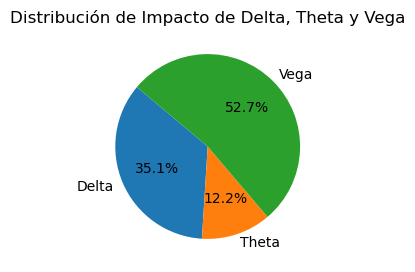

In [47]:
labels = ['Delta', 'Theta', 'Vega']
sizes = [delta_pct, theta_pct, vega_pct]
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Impacto de Delta, Theta y Vega')
plt.show()

In [48]:

# Create directory if it doesn't exist
output_directory = 'Output_csv'
os.makedirs(output_directory, exist_ok=True)

# Save the DataFrame using fecha as part of the filename
output_path = os.path.join(output_directory, f'Straddle_SPY_{fecha}.csv')
df.to_csv(output_path, index=False)

print(f"DataFrame saved to {output_path}")

DataFrame saved to Output_csv\Straddle_SPY_2024-11-07.csv
